In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import zipfile

file_path = '/content/Binary(Pens_Pencils).zip'

new_file = 'Pens_Pencils'

with zipfile.ZipFile(file_path,'r') as zip_ref:
  zip_ref.extractall(new_file)




In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelClassifier(nn.Module):
    def __init__(self):
        super(ModelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_drop = nn.Dropout2d()

        self.drop = nn.Dropout(0.4)
        # Calculate the flattened size dynamically
        # Create a dummy tensor with the expected input dimensions (batch_size=1, channels=1, height=28, width=28)
        # The size needs to match the input image size after transformations (28x28 grayscale in your case)
        dummy_input = torch.randn(1, 1, 32, 32)
        # Pass the dummy input through the convolutional and pooling layers
        # Ensure the operations match the forward pass up to the point of flattening
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(dummy_input), 2)))
        x = self.conv2(x)
        # Note: conv2_drop is not applied when calculating the size
        x = F.relu(self.bn2(F.max_pool2d(x, 2)))

        # Calculate the number of features before flattening
        self._to_linear = x.numel() // x.shape[0] # Divide by batch size

        self.dense = nn.Linear(self._to_linear, 100)
        self.out = nn.Linear(100, 2)

    def forward(self, x):
      # Layer 1
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
      # Layer 2
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.relu(self.bn2(F.max_pool2d(x, 2)))
        x = x.view(-1, self._to_linear)
      # Layer 3
        x = F.relu(self.dense(x))
        x = self.drop(x)
        x = self.out(x)

        return x

In [12]:
# class ModelClassifier(nn.Module):
#   def __init__(self):
#     super(ModelClassifier,self).__init__()
#     self.conv1 = nn.Conv2d(1,32,kernel_size=5)
#     self.bn1 = nn.BatchNorm2d(32)
#     self.conv2 = nn.Conv2d(32,64,kernel_size=5)
#     self.bn2 = nn.BatchNorm2d(64)
#     self.conv2_drop = nn.Dropout2d()
#     self.dense = nn.Linear(320,100)
#     self.out = nn.Linear(100,2)

#             # Calculate the flattened size dynamically
#         # Create a dummy tensor with the expected input dimensions (batch_size=1, channels=1, height=28, width=28)
#         # The size needs to match the input image size after transformations (28x28 grayscale in your case)
#     dummy_input = torch.randn(1, 1, 28, 28)
#         # Pass the dummy input through the convolutional and pooling layers
#     x = F.relu(self.bn1(F.max_pool2d(self.conv1(dummy_input), 2)))
#     x = self.conv2(x)
#     x = F.relu(self.bn2(F.max_pool2d(x, 2)))
#         # Calculate the number of features before flattening
#     self._to_linear = x.numel() // x.shape[0] # Divide by batch size

#     self.dense = nn.Linear(self._to_linear, 100)
#     self.out = nn.Linear(100, 2)

#   def forward(self,x):
#     x = F.relu(self.bn1(F.max_pool2d(self.conv1(x),2)))
#     x = self.conv2(x)
#     x = self.conv2_drop(x)
#     x = F.relu(self.bn2(F.max_pool2d(x,2)))
#     x = x.view(-1,self._to_linear)
#     x = F.relu(self.dense(x))
#     x = self.out(x)

#     return x

In [13]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Grayscale(),  # if not already grayscale
    transforms.Resize((32, 32)),  # resize if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# # Load dataset

dataset = datasets.ImageFolder('/content/Pens_Pencils/Binary(Pens_Pencils)',
                               transform=transform)

train_set = datasets.ImageFolder(
    '/content/Pens_Pencils/Binary(Pens_Pencils)/Train',  # Adjust path to your images folder
    transform=transform
)
validatation_set = datasets.ImageFolder(
    '/content/Pens_Pencils/Binary(Pens_Pencils)/Validation',  # Adjust path to your images folder
    transform=transform
)
test_set = datasets.ImageFolder(
    '/content/Pens_Pencils/Binary(Pens_Pencils)/Test',  # Adjust path to your images folder
    transform=transform
)
# # # Split into train/test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_set, test_set = random_split(dataset, [train_size, test_size])

# # Create DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
validatation_loader = DataLoader(validatation_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
loaders = {'train':train_loader,
          'validation': validatation_loader,
          'test': test_loader
}
class_name = train_set.classes
num_classes = len(class_name)

In [14]:
device = ''
if (torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'

model = ModelClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.00001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
# optimizer = nn.optim.Adam(model_parameters(), lr = 0.001)


loss_fn = nn.CrossEntropyLoss()

def validate(model,val_loader,loss_fn):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total

    return val_loss, accuracy

def train(model,epochs,patience=5):
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0

    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []


    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
                      f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        val_loss, val_acc = validate(model, loaders['validation'], loss_fn)
        train_loss /= len(loaders['train'])
        train_acc = 100. * correct / total



        train_accuracy_list.append(train_acc)
        val_accuracy_list.append(val_acc)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)


        print(f'\nEpoch {epoch}:')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Validation loss improved. Model saved.')
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epochs')
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch} epochs')
                break
    # plt.subplot(1,2,2)
    plt.plot(train_accuracy_list,label= 'Train Accuracy')
    plt.plot(val_accuracy_list,label= "Validation Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.xlabel("epocs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.subplot(1,2,1)
    plt.plot(train_loss_list,label="Training Loss")
    plt.plot(val_loss_list,label= "Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()

    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model


In [15]:
torch.save(model,'Pen_and_Pencil_md.pth')

In [16]:
# Test

def test_model(model, test_loader, print_samples=5):
    model.eval()
    class_names = test_loader.dataset.classes
    num_classes = len(class_names)

    # Initialize counters
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    samples_shown = 0

    print("\nTesting model...")
    print("-" * 50)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update statistics
            for label, prediction in zip(labels, predicted):
                class_total[label] += 1
                if label == prediction:
                    class_correct[label] += 1

            # Print balanced samples
            if samples_shown < print_samples:
                for i in range(len(images)):
                    if samples_shown >= print_samples:
                        break
                    if class_total[labels[i].item()] <= print_samples//num_classes:
                        pred_name = class_names[predicted[i].item()]
                        true_name = class_names[labels[i].item()]
                        correct_str = "✓" if predicted[i] == labels[i] else "✗"
                        print(f"  {correct_str} Pred: {pred_name:<15} (True: {true_name})")
                        samples_shown += 1

    # Calculate overall and per-class accuracy
    total_correct = sum(class_correct)
    total = sum(class_total)
    overall_accuracy = 100 * total_correct / total

    print("\nClass-wise Performance:")
    print("-" * 50)
    for i in range(num_classes):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{class_names[i]:<15}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")

    print("-" * 50)
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total})")
    print("-" * 50)

    return overall_accuracy

Epoch: 1 [0/196 (0%)]	Loss: 0.661232

Epoch 1:
Train Loss: 0.6675 | Accuracy: 60.20%
Val Loss: 0.6924 | Accuracy: 47.62%
Validation loss improved. Model saved.
Epoch: 2 [0/196 (0%)]	Loss: 0.748612

Epoch 2:
Train Loss: 0.6468 | Accuracy: 65.82%
Val Loss: 0.6948 | Accuracy: 54.76%
No improvement in validation loss for 1 epochs
Epoch: 3 [0/196 (0%)]	Loss: 0.645121

Epoch 3:
Train Loss: 0.6316 | Accuracy: 67.86%
Val Loss: 0.6891 | Accuracy: 52.38%
Validation loss improved. Model saved.
Epoch: 4 [0/196 (0%)]	Loss: 0.602875

Epoch 4:
Train Loss: 0.6272 | Accuracy: 67.35%
Val Loss: 0.6915 | Accuracy: 52.38%
No improvement in validation loss for 1 epochs
Epoch: 5 [0/196 (0%)]	Loss: 0.628635

Epoch 5:
Train Loss: 0.5920 | Accuracy: 70.92%
Val Loss: 0.6864 | Accuracy: 57.14%
Validation loss improved. Model saved.


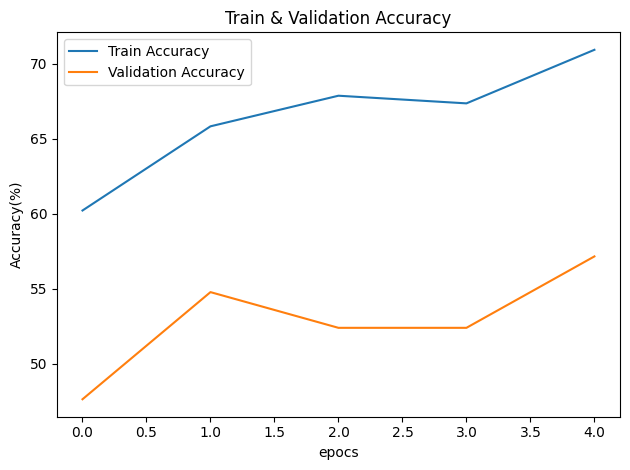

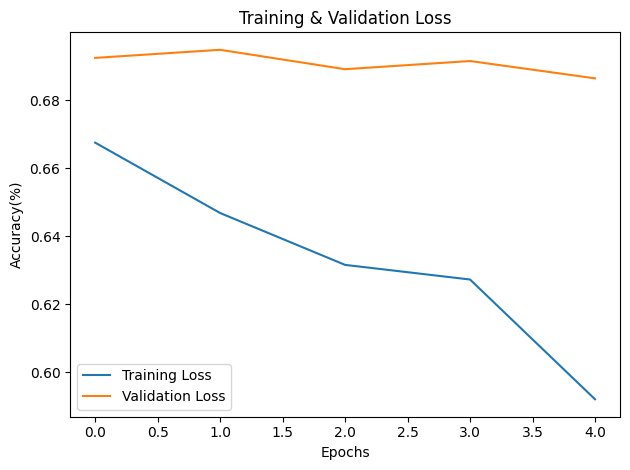

ModelClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (drop): Dropout(p=0.4, inplace=False)
  (dense): Linear(in_features=1600, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=2, bias=True)
)

In [17]:
train(model,5)

In [18]:
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision

def predict_custom_image(model, image_path, class_names):
    """
    Predict image class with automatic device detection (CUDA if available, otherwise CPU)

    Args:
        model: Trained PyTorch model
        image_path: Path to image file
        class_names: List of class names (order must match training)

    Returns:
        tuple: (predicted_class, confidence, all_probs)
    """

    # Set device automatically
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Model setup
    model = model.to(device)
    model.eval()

    # Preprocessing - MUST MATCH TRAINING PREPROCESSING
    # Use the same transformations as used for training data loaders
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to 1 channel grayscale
        transforms.Resize((32, 32)),  # Resize to the expected input size (28x28)
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # Use the same normalization for grayscale
    ])

    try:
        # Load and preprocess image
        # Remove .convert('RGB') to allow transforms.Grayscale() to work correctly
        img = Image.open(image_path)
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Prediction
        with torch.no_grad():
            output = model(img_tensor)
            # Apply softmax to get probabilities
            probs = torch.nn.functional.softmax(output[0], dim=0)
            conf, pred_idx = torch.max(probs, 0)

        # Prepare results
        all_probs = {class_names[i]: f"{probs[i].item()*100:.1f}%"
                    for i in range(len(class_names))}

        return class_names[pred_idx], conf.item(), all_probs

    except Exception as e:
        # Re-raise the exception with a more informative message
        raise RuntimeError(f"Prediction failed: {str(e)}")


# Example usage
# Make sure 'dataset' is the ImageFolder instance you want to use for getting class names
# In your setup, 'dataset' is created directly under Custom_DataSet, while test_set is
# created under Custom_DataSet/Test. For prediction on individual images, it's often
# convenient to use a dataset object that reflects the classes you trained on.
# Using 'train_set' or 'test_set' here would also work as they share the same class structure
# derived from the subfolders. Let's use train_set as it's generally available.
# However, the original code uses 'dataset' from the root, which should also work
# if the root contains subfolders corresponding to the classes. Let's stick to 'dataset'
# as per the original error context.

# Ensure the device variable is defined (it is in your global variables)
# device = 'cuda' if torch.cuda.is_available() else 'cpu' # This is defined earlier in your notebook

# Ensure the dataset object is available and correctly instantiated ImageFolder
# dataset = datasets.ImageFolder('/content/Pens_Pencils/Custom_DataSet', transform=transform) # This is defined earlier


In [19]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Define a dictionary to store layer outputs
layer_outputs = {}

def get_layer_output(name):
    """Hook function to store layer output"""
    def hook(model, input, output):
        layer_outputs[name] = output.detach()
    return hook

def predict_with_debug(model, image_path, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Register hooks for all layers
    hooks = []
    for name, layer in model.named_children():
        hook = layer.register_forward_hook(get_layer_output(name))
        hooks.append(hook)

    # Preprocess image
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Forward pass (captures all layer outputs in `layer_outputs`)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        conf, pred_idx = torch.max(probs, 0)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Print layer outputs (for debugging)
    for name, output in layer_outputs.items():
        print(f"Layer: {name}")
        print(f"Shape: {output.shape}")
        print(f"Min: {output.min().item()}, Max: {output.max().item()}")
        print("-" * 50)

    # Return prediction results
    all_probs = {class_names[i]: f"{probs[i].item()*100:.1f}%"
                for i in range(len(class_names))}
    return class_names[pred_idx], conf.item(), all_probs

In [20]:
test_model(model,test_loader)


Testing model...
--------------------------------------------------

Class-wise Performance:
--------------------------------------------------
Pen            : 28.57% (6/21)
Pencil         : 90.48% (19/21)
--------------------------------------------------

Overall Accuracy: 59.52% (25/42)
--------------------------------------------------


59.523809523809526

In [21]:
def create_confusion_matrix_manual(model, test_loader, num_classes, device):
    model.eval()
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # Normalize the confusion matrix
    cm_normalized = confusion_matrix / confusion_matrix.sum(1).view(-1, 1)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_normalized.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(torch.arange(num_classes))
    plt.yticks(torch.arange(num_classes))

    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f"{confusion_matrix[i, j]:.0f}\n({cm_normalized[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")

    plt.show()

    return confusion_matrix

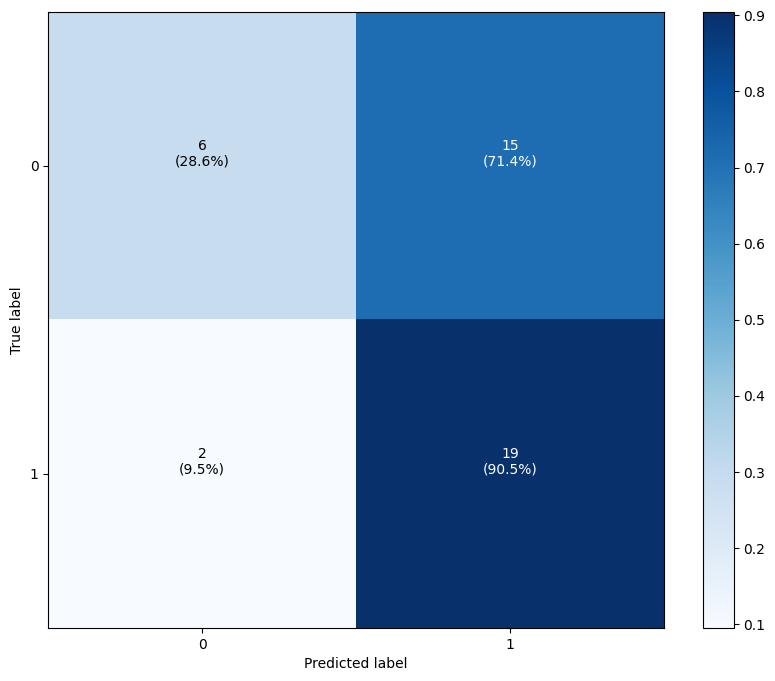

tensor([[ 6., 15.],
        [ 2., 19.]])

In [22]:
create_confusion_matrix_manual(model,test_loader=test_loader,num_classes=num_classes,device=device)

In [23]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/pencil_280523090.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


RuntimeError: Prediction failed: [Errno 2] No such file or directory: '/content/pencil_280523090.jpg'

In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/VRR-2452_seasonalTouchFall-autmnOrange_RB-02_875x700.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/51TkKa5QdgL.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/bud.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/image-asset.jpeg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/4539621__64029.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/Ohto_2_Eraser_Refill.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_with_debug(
            model=model,
            image_path='/content/Ohto_2_Eraser_Refill.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

In [ ]:
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_with_debug(
            model=model,
            image_path='/content/pc.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

In [ ]:
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_with_debug(
            model=model,
            image_path='/content/610qJ+apPML._AC_UF1000,1000_QL80_.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")